In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, plot_confusion_matrix, accuracy_score
import xgboost as xgb


import warnings
warnings.filterwarnings('ignore')

### Exploration Data Analysis

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64


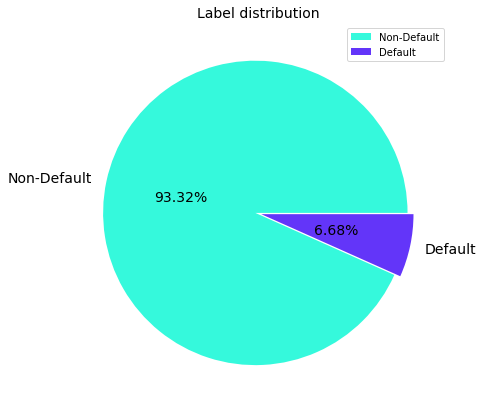

In [147]:
df=pd.read_csv('cs-training.csv')
df_test=pd.read_csv('cs-test.csv')
# Inspect target distribution
print(df['SeriousDlqin2yrs'].value_counts())

pie, ax = plt.subplots(figsize=[10,7])
labels = ['Non-Default', 'Default']
colors = ['#35f9dc', '#6335f9']
plt.pie(x = df['SeriousDlqin2yrs'].value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 14}, colors = colors)
plt.title('Label distribution',fontsize=14)
plt.legend(loc='upper right')
plt.show()

In [148]:
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [149]:
df.head()
print(df.shape)

(150000, 11)


In [150]:
# Check Missing Values and Unique Values
pd.concat([df.isna().sum(),df.nunique()],axis=1).rename(columns = {0:'Nulls',1:'Uniques'})

,Nulls,Uniques
SeriousDlqin2yrs,0,2
RevolvingUtilizationOfUnsecuredLines,0,125728
age,0,86
NumberOfTime30-59DaysPastDueNotWorse,0,16
DebtRatio,0,114194
MonthlyIncome,29731,13594
NumberOfOpenCreditLinesAndLoans,0,58
NumberOfTimes90DaysLate,0,19
NumberRealEstateLoansOrLines,0,28
NumberOfTime60-89DaysPastDueNotWorse,0,13


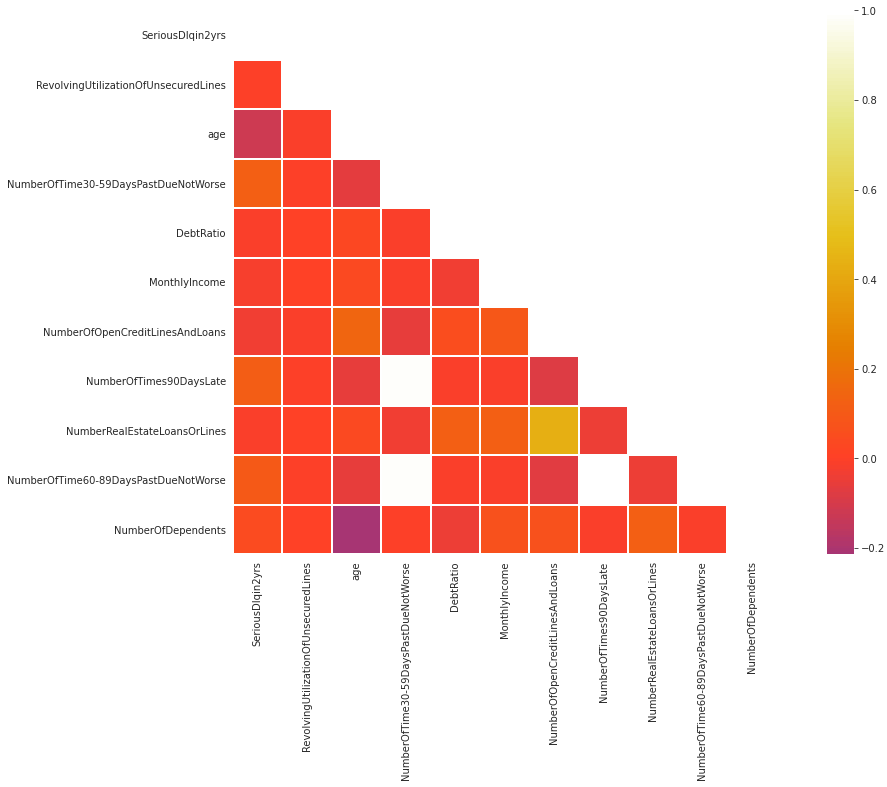

In [151]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, cmap="CMRmap", center=0, linewidths=0.1, square=True)

In [152]:
df.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

Text(0.5, 1.0, 'Correlation coefficient of the variables')

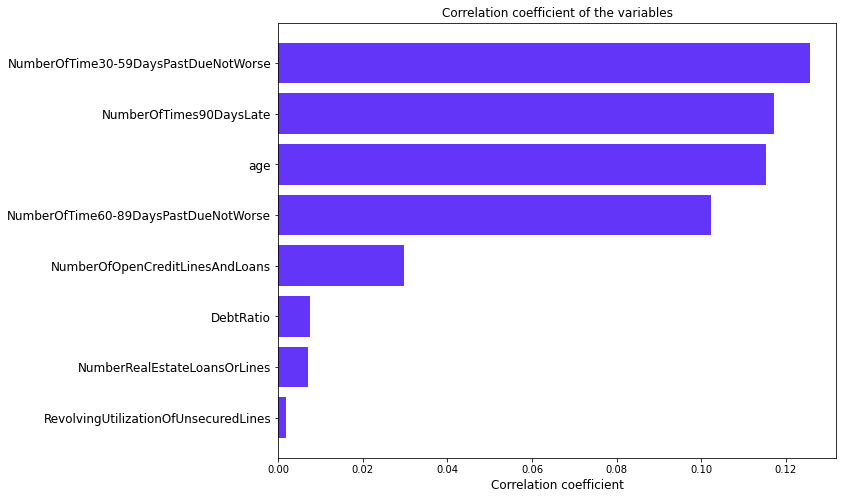

In [153]:
x_cols = [col for col in df.columns if col not in ['SeriousDlqin2yrs'] if df[col].dtype!='object']
labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(df[col].values, df.SeriousDlqin2yrs,values)[0, 1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df= corr_df.dropna(how='any',axis=0)
corr_df.corr_values=corr_df.corr_values.apply(lambda x: abs(x))
corr_df = corr_df.sort_values(by = 'corr_values')
ind = corr_df.col_labels
width = 0.5
fig,ax = plt.subplots(figsize = (10,8))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='#6335f9')
 
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal',fontsize=12)
ax.set_xlabel('Correlation coefficient',fontsize=12)
ax.set_title('Correlation coefficient of the variables',fontsize=12)

In [154]:
# Some features present a small distribution
for i in df.columns[1:]:
    if len(df[i].value_counts()) < 14:
        print(f'The column {i} has the following distribution: \n{df[i].value_counts()}')
        print('======================================')

The column NumberOfTime60-89DaysPastDueNotWorse has the following distribution: 
0     142396
1       5731
2       1118
3        318
98       264
4        105
5         34
6         16
7          9
96         5
8          2
11         1
9          1
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: int64
The column NumberOfDependents has the following distribution: 
0.0     86902
1.0     26316
2.0     19522
3.0      9483
4.0      2862
5.0       746
6.0       158
7.0        51
8.0        24
10.0        5
9.0         5
20.0        1
13.0        1
Name: NumberOfDependents, dtype: int64


In [155]:
# Filtering the features with 0 variance
no_var = df.var() == 0
print(df.var()[no_var])
print('\n')

# Drop features with 0 variance --- these features will not help in the performance of the model
df.drop(df.var()[no_var].index, axis = 1, inplace = True)
print(df.var())
print(df.shape)

Series([], dtype: float64)


SeriousDlqin2yrs                        6.237283e-02
RevolvingUtilizationOfUnsecuredLines    6.237775e+04
age                                     2.182080e+02
NumberOfTime30-59DaysPastDueNotWorse    1.757941e+01
DebtRatio                               4.152704e+06
MonthlyIncome                           2.069189e+08
NumberOfOpenCreditLinesAndLoans         2.648081e+01
NumberOfTimes90DaysLate                 1.738309e+01
NumberRealEstateLoansOrLines            1.276382e+00
NumberOfTime60-89DaysPastDueNotWorse    1.726552e+01
NumberOfDependents                      1.243417e+00
dtype: float64
(150000, 11)


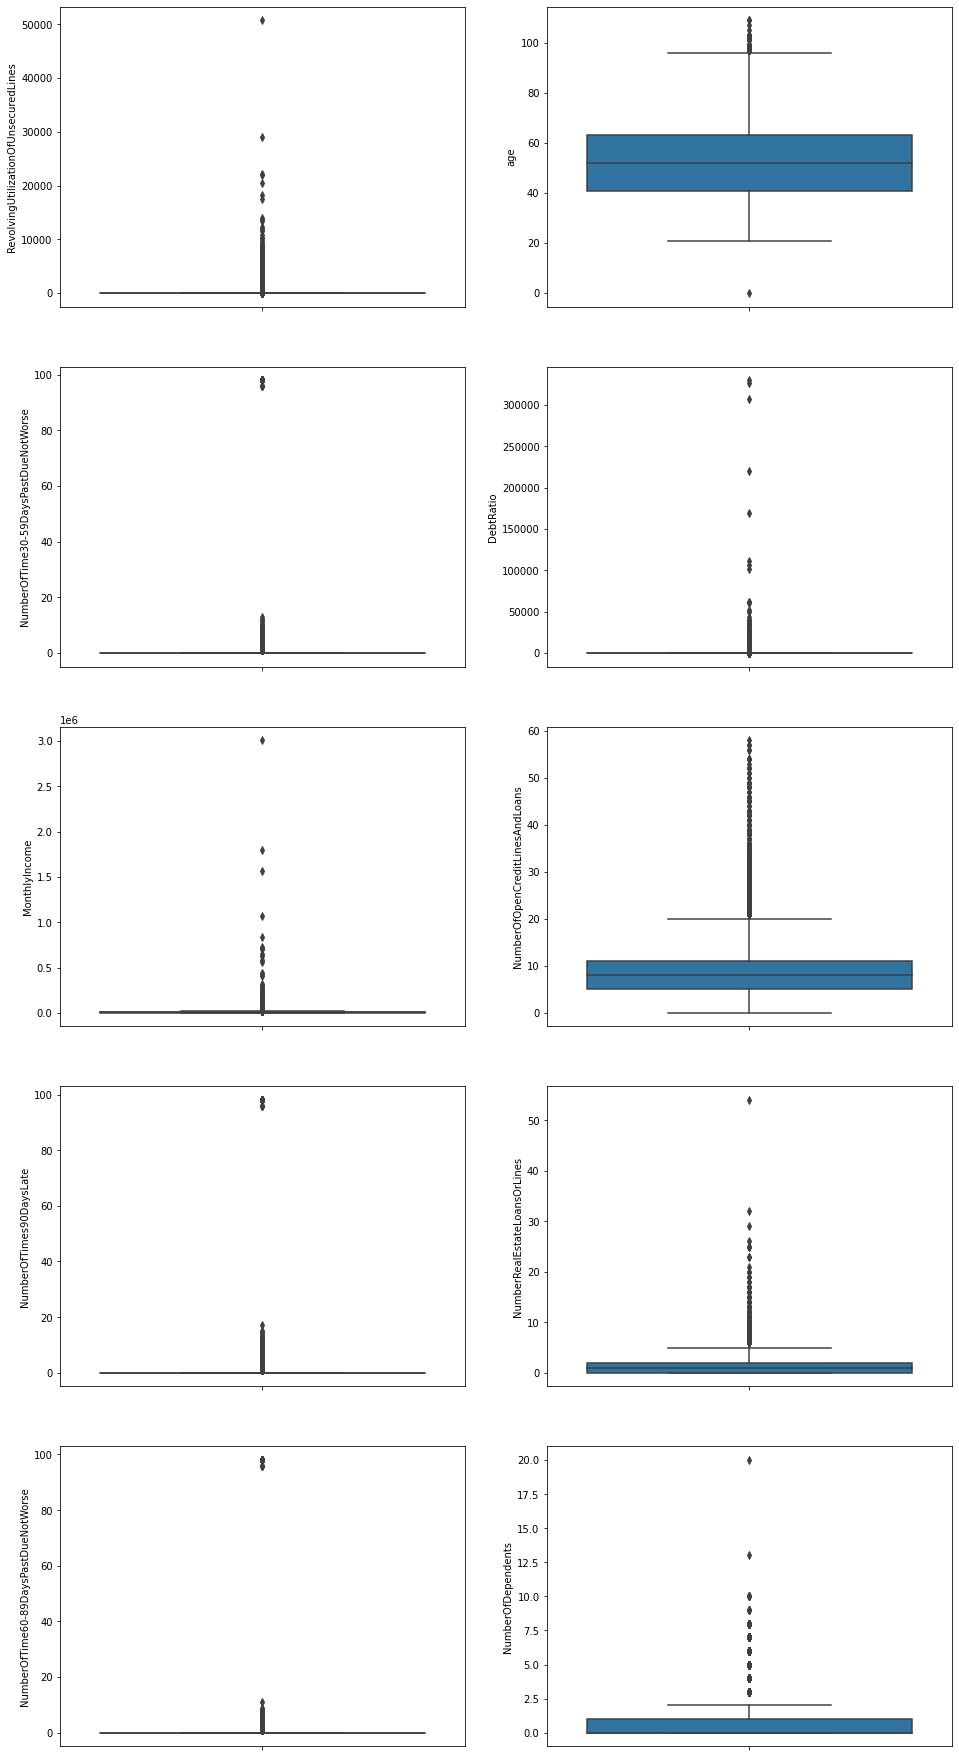

In [156]:
X = df.drop(columns='SeriousDlqin2yrs')
y = df['SeriousDlqin2yrs']
columns = X.columns
# Investigate the distribution of our features using boxplots
ncols = 2
nrows = (len(columns) + 1) // ncols 
fig, ax = plt.subplots(nrows,ncols,figsize=(16, 32))

for ix in range(nrows):
    for iy in range(ncols):
        i = ix*ncols+iy
        if (i < len(columns)):
            col_name = columns[i]
            sns.boxplot(y=col_name,  ax=ax[ix][iy], data=X)

#plt.show()            

### Fill Null Values & Standardization

In [157]:
preprocessing_pipeline = Pipeline([
    ('impoter', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])
X= preprocessing_pipeline.fit_transform(X)

### SMOTE Sampling

In [158]:
smt = SMOTEENN(random_state=1)
X_smt, y_smt = smt.fit_resample(X, y)

In [159]:
pd.concat([df['SeriousDlqin2yrs'].value_counts().rename('original'), y_smt.value_counts().rename('smoteenn')], axis=1)

,original,smoteenn
0,139974,109696
1,10026,121271


### modeling

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X_smt, y_smt, train_size=0.8)
model = RandomForestClassifier(max_features='sqrt', min_samples_leaf=1, min_samples_split=2,
                                     bootstrap=False, n_estimators = 360)

model.fit(X_train, y_train)

predictions = model.predict(X_test)

f1 score = 0.9708366268669136
ROC AUC score = 0.9698564790256153
accuracy score = 0.9696497380612201


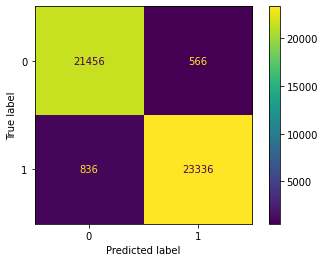

In [161]:
print("f1 score = {}".format(f1_score(y_test, predictions)))

print("ROC AUC score = {}".format(roc_auc_score(y_test, predictions)))

print("accuracy score = {}".format(accuracy_score(y_test, predictions)))

display(plot_confusion_matrix(model, X_test, y_test))

In [162]:
xgc = xgb.XGBClassifier(booster='gbtree', tree_method='hist', colsample_bytree=0.95,
                        learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=240, n_jobs=-1,
                        objective='multi:softmax', reg_alpha=0, reg_lambda=2, scale_pos_weight=1, num_class=2)


[02:30:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:30:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1 score = 0.9604370206954512
ROC AUC score = 0.9599049311676996
accuracy score = 0.9592371303632506


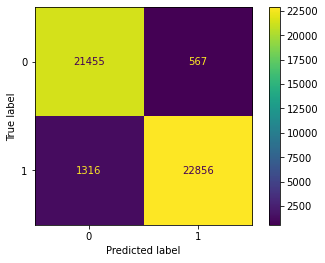

In [163]:
xgc.fit(X_train, y_train)

predictions = xgc.predict(X_test)

print("f1 score = {}".format(f1_score(y_test, predictions)))

print("ROC AUC score = {}".format(roc_auc_score(y_test, predictions)))

print("accuracy score = {}".format(accuracy_score(y_test, predictions)))

display(plot_confusion_matrix(xgc, X_test, y_test))

f1 score = 0.796553590761458
ROC AUC score = 0.8083596747151874
accuracy score = 0.8047365458717582


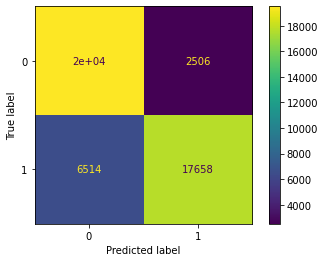

In [164]:
clf = LogisticRegression(penalty='l2',random_state=0).fit(X_train, y_train)
predictions = clf.predict(X_test)

print("f1 score = {}".format(f1_score(y_test, predictions)))

print("ROC AUC score = {}".format(roc_auc_score(y_test, predictions)))

print("accuracy score = {}".format(accuracy_score(y_test, predictions)))

display(plot_confusion_matrix(clf, X_test, y_test))

### Test the model without SOMTE Sampling

f1 score = 0.303477344573235
ROC AUC score = 0.5993482990979861
accuracy score = 0.9339


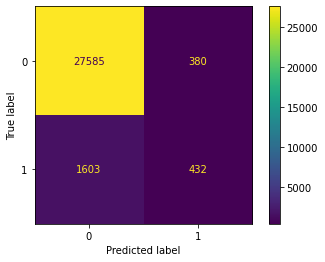

In [165]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, train_size=0.8)
model1 = RandomForestClassifier(max_features='sqrt', min_samples_leaf=1, min_samples_split=2,
                                     bootstrap=False, n_estimators = 360)

model1.fit(X_train1, y_train1)

predictions1 = model1.predict(X_test1)

print("f1 score = {}".format(f1_score(y_test1, predictions1)))

print("ROC AUC score = {}".format(roc_auc_score(y_test1, predictions1)))

print("accuracy score = {}".format(accuracy_score(y_test1, predictions1)))

display(plot_confusion_matrix(model1, X_test1, y_test1))

f1 score = 0.6480797636632201
ROC AUC score = 0.9021318768502748
accuracy score = 0.9364666666666667


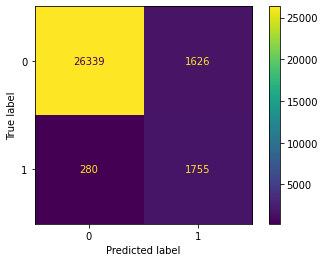

In [166]:
predictions2 = model.predict(X_test1)
print("f1 score = {}".format(f1_score(y_test1, predictions2)))

print("ROC AUC score = {}".format(roc_auc_score(y_test1, predictions2)))

print("accuracy score = {}".format(accuracy_score(y_test1, predictions2)))

display(plot_confusion_matrix(model, X_test1, y_test1))

### Train Tree models without standarlization

[02:32:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:32:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1 score = 0.28211773417252867
ROC AUC score = 0.589655993890366
accuracy score = 0.9353666666666667


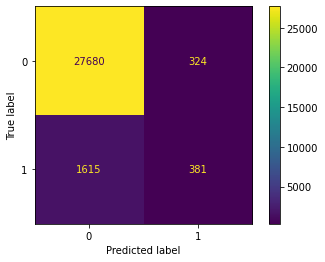

In [167]:
X = df.drop(columns='SeriousDlqin2yrs')
y = df['SeriousDlqin2yrs']
preprocessing_pipeline = Pipeline([
    ('impoter', SimpleImputer(strategy='mean'))])
X1= preprocessing_pipeline.fit_transform(X)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X1, y, train_size=0.8)

xgc2 = xgb.XGBClassifier(booster='gbtree', tree_method='hist', colsample_bytree=0.95,
                        learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=240, n_jobs=-1,
                        objective='multi:softmax', reg_alpha=0, reg_lambda=2, scale_pos_weight=1, num_class=2)

xgc2.fit(X_train2, y_train2)

predictions3 = xgc2.predict(X_test2)

print("f1 score = {}".format(f1_score(y_test2, predictions3)))

print("ROC AUC score = {}".format(roc_auc_score(y_test2, predictions3)))

print("accuracy score = {}".format(accuracy_score(y_test2, predictions3)))

display(plot_confusion_matrix(xgc2, X_test2, y_test2))

### Train the final model and predict

In [168]:
df_test.drop(['Unnamed: 0'], axis = 1, inplace = True)

X_real_test = df_test.drop(['SeriousDlqin2yrs'], axis = 1)

X_real_test=X_real_test.iloc[:300]

preprocessing_pipeline = Pipeline([
    ('impoter', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

X_real_test= preprocessing_pipeline.fit_transform(X_real_test)

In [169]:
final_model = RandomForestClassifier(max_features='sqrt', min_samples_leaf=1, min_samples_split=2,
                                     bootstrap=False, n_estimators = 360)

final_model.fit(X_smt, y_smt)

final_predictions = final_model.predict_proba(X_real_test)


In [170]:
final_predictions

array([[0.61293557, 0.38706443],
       [0.7       , 0.3       ],
       [0.88596223, 0.11403777],
       [0.15833333, 0.84166667],
       [0.66944444, 0.33055556],
       [0.7744576 , 0.2255424 ],
       [0.72222222, 0.27777778],
       [0.14722222, 0.85277778],
       [0.85833333, 0.14166667],
       [0.36944444, 0.63055556],
       [0.88883624, 0.11116376],
       [0.81666667, 0.18333333],
       [0.96007232, 0.03992768],
       [0.81101488, 0.18898512],
       [0.71388889, 0.28611111],
       [0.84718235, 0.15281765],
       [0.84166667, 0.15833333],
       [0.83590062, 0.16409938],
       [0.09444444, 0.90555556],
       [0.68611111, 0.31388889],
       [0.85822499, 0.14177501],
       [0.9443361 , 0.0556639 ],
       [0.94163905, 0.05836095],
       [0.16944444, 0.83055556],
       [0.11111111, 0.88888889],
       [0.68055556, 0.31944444],
       [0.51390775, 0.48609225],
       [0.9749443 , 0.0250557 ],
       [0.83333333, 0.16666667],
       [0.83055556, 0.16944444],
       [0.

In [176]:
df_result=pd.DataFrame({'id':np.array(range(300)),'probability':final_predictions.T[0]})
df_result.to_csv('final_result.csv')